### Data fields
* DBNOs - Number of enemy players knocked.
* assists - Number of enemy players this player damaged that were killed by teammates.
* boosts - Number of boost items used.
* damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
* headshotKills - Number of enemy players killed with headshots.
* heals - Number of healing items used.
* Id - Player’s Id
* killPlace - Ranking in match of number of enemy players killed.
* killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
* killStreaks - Max number of enemy players killed in a short amount of time.
* kills - Number of enemy players killed.
* longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
* matchDuration - Duration of match in seconds.
* matchId - ID to identify match. There are no matches that are in both the training and testing set.
* matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
* rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
* revives - Number of times this player revived teammates.
* rideDistance - Total distance traveled in vehicles measured in meters.
* roadKills - Number of kills while in a vehicle.
* swimDistance - Total distance traveled by swimming measured in meters.
* teamKills - Number of times this player killed a teammate.
* vehicleDestroys - Number of vehicles destroyed.
* walkDistance - Total distance traveled on foot measured in meters.
* weaponsAcquired - Number of weapons picked up.
* winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
* groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
* numGroups - Number of groups we have data for in the match.
* maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
ortrain = pd.read_csv('train_V2.csv')
ortrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


In [3]:
# filter out recorders with null target, use matchId
matchIdout = ortrain[ortrain['winPlacePerc'].isnull()].matchId.values
ortrain = ortrain[-ortrain.matchId.isin(matchIdout)]
ortrain.shape

(4446965, 29)

In [4]:
pd.options.display.max_columns = 30
print('Total count of teams: ', ortrain.groupId.nunique()) # number of teams / same team in dif match has dif groupId
print('Total count of matches: ', ortrain.matchId.nunique()) # number of games in datasetv
ortrain[:3]
# for id: Player-Id drop, groupId: identify group within match, matchId: identify match

Total count of teams:  2026744
Total count of matches:  47964


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.0,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.8,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.0,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.0,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.0,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.8,2,0,0.7755


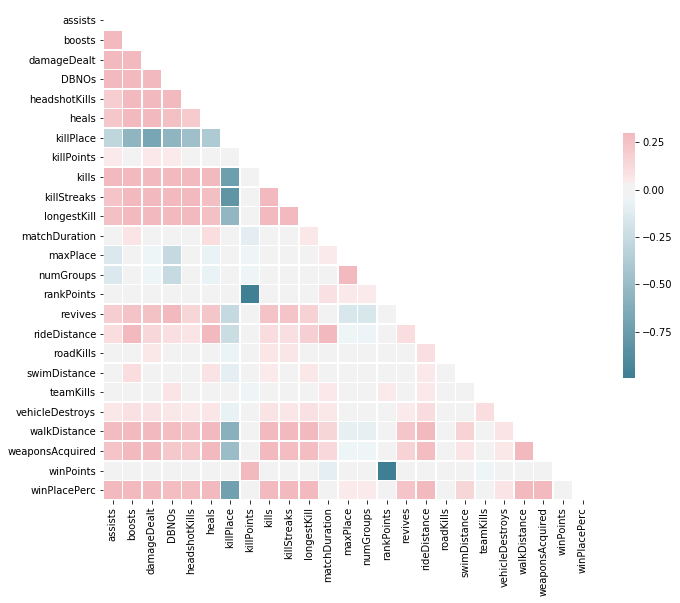

In [5]:
# drop identifier / categorical columns to form a correlation matrix 
coldrop = ['Id', 'groupId', 'matchId', 'matchType']
col_corr = [col for col in ortrain.columns if col not in coldrop]

corr = ortrain[col_corr].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True  # Return the indices for the upper-triangle of arr
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask = mask, cmap = cmap, vmax=0.3, center=0, square=True, linewidths=0.5, cbar_kws={"shrink":0.5})


In [6]:
# add 2 columns: count of teams for each match; count of records per team
# for count of players in each team, dif match may use same groupId, test value counts over 30 entries
tc = ortrain.groupby('matchId').size().reset_index(name='playercount_permatch')
train = ortrain.join(tc.set_index('matchId'), on='matchId')
train['playercount_perteam'] = ortrain.groupby(['matchId', 'groupId'])['Id'].transform('count')
print(train.shape)
# sum(train.playercount_permatch < 101) == len(train)
# test if all matches have less than 100 players
train[:3]

(4446965, 31)


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,...,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playercount_permatch,playercount_perteam
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.0,1306,...,28,26,-1,0,0.0000,0,0.00,0,0,244.8,1,1466,0.4444,96,4
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.0,1777,...,26,25,1484,0,0.0045,0,11.04,0,0,1434.0,5,0,0.6400,91,4
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.0,1318,...,50,47,1491,0,0.0000,0,0.00,0,0,161.8,2,0,0.7755,98,2


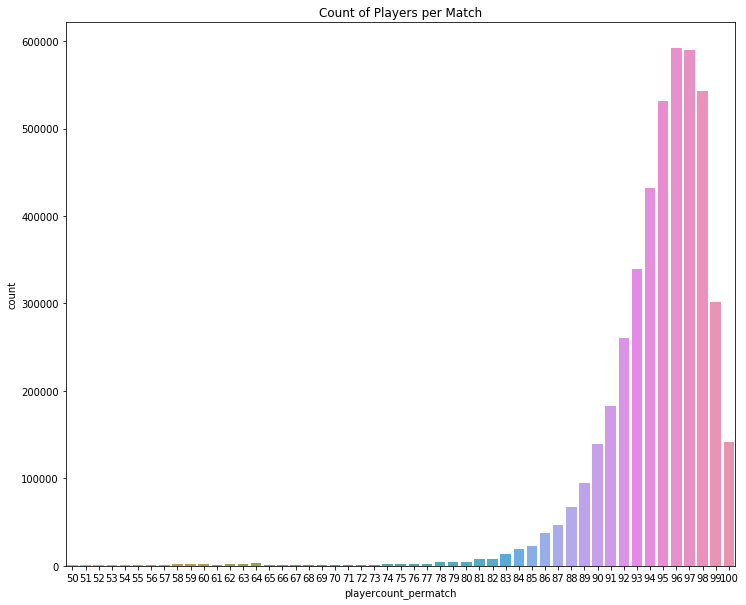

In [7]:
player_50 = train[train.playercount_permatch > 49]
plt.figure(figsize=(12, 10))
sns.countplot(player_50.playercount_permatch)
plt.title('Count of Players per Match')
plt.show()

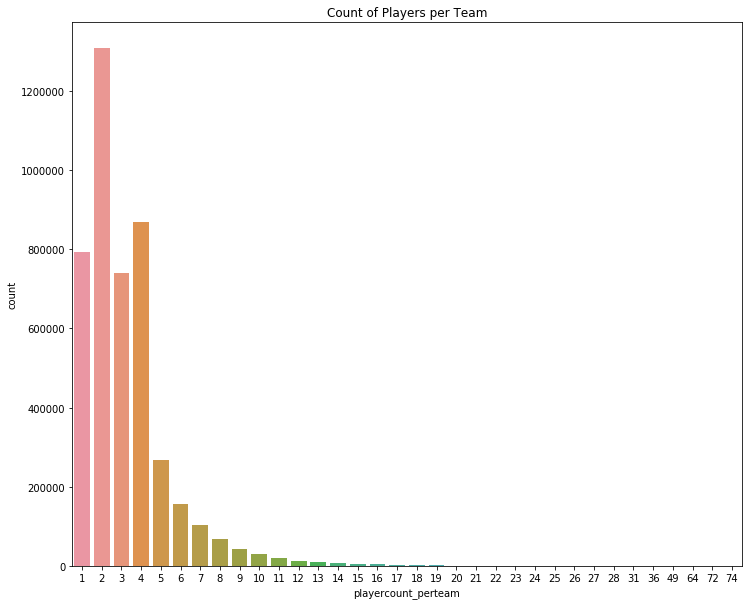

In [8]:
# train.recordcount_perteam.value_counts()
plt.figure(figsize=(12, 10))
sns.countplot(train.playercount_perteam)
plt.title('Count of Players per Team')
plt.show()
# records per team: share same matchId and groupId, field has more value entries than 1,2,4 (MatchType)


In [9]:
len(train[(train.playercount_perteam < 5)])/len(train)
# test the ratio of players per team less or equal to 4
# necessary to drop player count above 4??

0.8347870963679723

In [11]:
ortrain.matchType.value_counts()
# fpp/tpp, mormal, flare_4, crash_2, 

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536761
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

In [12]:
# split matchtype into type and persepctive
# game types: solo, duo, squad
typedic = {'squad-fpp': 'squad', 'duo-fpp': 'duo', 'squad': 'squad', 'solo-fpp': 'solo', 'duo': 'duo', 
           'solo': 'solo','normal-squad-fpp': 'squad', 'crashfpp': 'duo', 'normal-duo-fpp': 'duo', 
           'flaretpp': 'squad', 'normal-solo-fpp': 'solo', 'flarefpp': 'squad', 'normal-squad': 'squad',
           'crashtpp': 'duo', 'normal-solo': 'solo', 'normal-duo': 'duo'}
# perspective types: fpp, tpp
ppdic = {'squad-fpp': 'fpp', 'duo-fpp': 'fpp', 'squad': np.nan, 'solo-fpp': 'fpp', 'duo': np.nan, 
           'solo': np.nan,'normal-squad-fpp': 'fpp', 'crashfpp': 'fpp', 'normal-duo-fpp': 'fpp', 
           'flaretpp': 'tpp', 'normal-solo-fpp': 'fpp', 'flarefpp': 'fpp', 'normal-squad': np.nan,
           'crashtpp': 'tpp', 'normal-solo': np.nan, 'normal-duo': np.nan}

feature = pd.DataFrame(columns=['type', 'perspective'])
feature['type'] = train['matchType'].map(typedic)
feature['perspective'] = train['matchType'].map(ppdic)
print(feature.type.value_counts())
print(feature.perspective.value_counts())

squad    2403625
duo      1322628
solo      720712
Name: type, dtype: int64
fpp    3320988
tpp       2876
Name: perspective, dtype: int64


In [13]:
types = pd.get_dummies(feature['type'], prefix='type')
pps = pd.get_dummies(feature['perspective'])
add_feature = pd.concat([types, pps], axis = 1)
add_feature[:3]
# get dummy variables to deal with np.nan

,type_duo,type_solo,type_squad,fpp,tpp
0,0,0,1,1,0
1,0,0,1,1,0
2,1,0,0,0,0


In [14]:
add_feature['moveDistance'] = train['rideDistance'] + train['swimDistance'] + train['walkDistance']
add_feature['boost_heals'] = train['boosts'] + train['heals']
add_feature['equipment'] = train['boosts'] + train['heals'] + train['weaponsAcquired']
add_feature['teamwork'] = train['assists'] + train['revives'] - train['teamKills']
add_feature['headshot/kills'] = train['headshotKills'] / train['kills']
add_feature['headshot/kills'].fillna(0, inplace=True)
add_feature['killstreak/kills'] = train['killStreaks'] / train['kills']
add_feature['killstreak/kills'].fillna(0, inplace=True)
add_feature['kills/duration'] = train['kills'] / train['matchDuration'] # scale
add_feature['damage/duration'] = train['damageDealt'] / train['matchDuration']
add_feature['killplace/playercount'] = train['killPlace'] / train['playercount_permatch'] 
# 272 records killplace>playerscount -- abnormal


In [15]:
# len(train) == sum(train['kills'] > train['headshotKills']-1)
# check abnormal -> True
# len(train) - sum(train['DBNOs'] > train['kills']-1) # 1043767
# conditions: kills >> knock downs, 
# explaination: in the same team B killed an enemy that knocked down by A. 

In [18]:
add_feature[:3]

,type_duo,type_solo,type_squad,fpp,tpp,moveDistance,boost_heals,equipment,teamwork,headshot/kills,killstreak/kills,kills/duration,damage/duration,killplace/playercount
0,0,0,1,1,0,244.8000,0,1,0,0.0,0.0,0.0,0.000000,0.625000
1,0,0,1,1,0,1445.0445,0,5,0,0.0,0.0,0.0,0.051474,0.626374
2,1,0,0,0,0,161.8000,0,2,1,0.0,0.0,0.0,0.051593,0.479592


In [20]:
# groupby + transform
feature2 = train.copy()
feature2['teamdamage'] = feature2.groupby(['matchId', 'groupId'])['damageDealt'].transform('sum')
feature2['teamDBNO'] = feature2.groupby(['matchId', 'groupId'])['DBNOs'].transform('sum')
feature2['teamkill'] = feature2.groupby(['matchId', 'groupId'])['kills'].transform('sum')

In [21]:
add_feature['damage_prop'] = feature2['damageDealt'] / feature2['teamdamage']
add_feature['knock_prop'] = feature2['DBNOs'] / feature2['teamDBNO']
add_feature['kill_prop'] = feature2['kills'] / feature2['teamkill']
cols = ['damage_prop','knock_prop','kill_prop']
add_feature[cols] = add_feature[cols].fillna(0)

In [22]:
add_feature.isnull().sum()

type_duo                 0
type_solo                0
type_squad               0
fpp                      0
tpp                      0
moveDistance             0
boost_heals              0
equipment                0
teamwork                 0
headshot/kills           0
killstreak/kills         0
kills/duration           0
damage/duration          0
killplace/playercount    0
damage_prop              0
knock_prop               0
kill_prop                0
dtype: int64

In [23]:
add_feature.columns

Index(['type_duo', 'type_solo', 'type_squad', 'fpp', 'tpp', 'moveDistance',
       'boost_heals', 'equipment', 'teamwork', 'headshot/kills',
       'killstreak/kills', 'kills/duration', 'damage/duration',
       'killplace/playercount', 'damage_prop', 'knock_prop', 'kill_prop'],
      dtype='object')

In [24]:
ntrainor = pd.concat([train, add_feature], axis = 1)
coldrop = ['Id', 'groupId', 'matchId', 'matchType']
ntrain = ntrainor.drop(coldrop, axis = 1)

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_df = scaler.fit_transform(ntrain)
scaled_df = pd.DataFrame(scaled_df, columns=ntrain.columns)

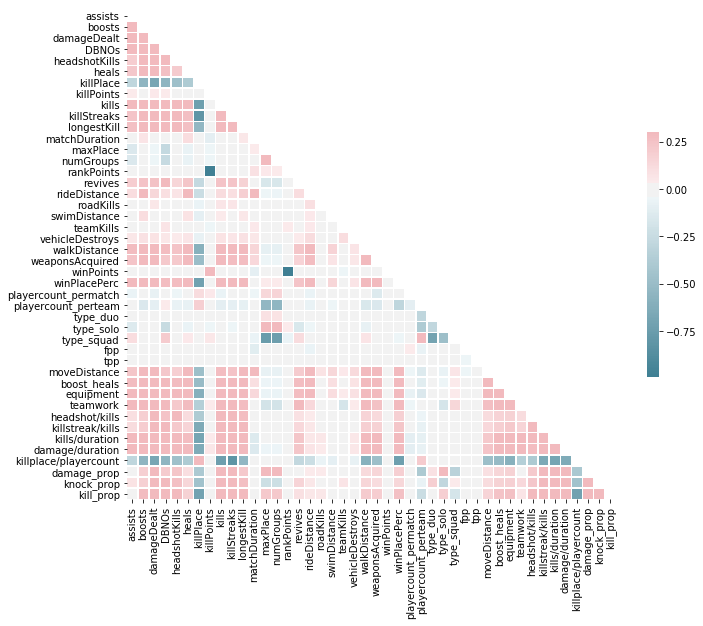

In [26]:
corr = scaled_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True 
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask = mask, cmap = cmap, vmax=0.3, center=0, square=True, linewidths=0.5, cbar_kws={"shrink":0.5})


In [28]:
# combine features with orig train data, without scale
# since no distance based algo is planned to use, scale is not needed
# af: add_feature
train_af0 = pd.concat([train, add_feature], axis=1)
drop_col = ['Id', 'groupId', 'matchId', 'matchType']
train_af1 = train_af0.drop(drop_col, axis=1)
pd.options.display.max_columns = len(train_af1.columns)
train_af1[:3]

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playercount_permatch,playercount_perteam,type_duo,type_solo,type_squad,fpp,tpp,moveDistance,boost_heals,equipment,teamwork,headshot/kills,killstreak/kills,kills/duration,damage/duration,killplace/playercount,damage_prop,knock_prop,kill_prop
0,0,0,0.00,0,0,0,60,1241,0,0,0.0,1306,28,26,-1,0,0.0000,0,0.00,0,0,244.8,1,1466,0.4444,96,4,0,0,1,1,0,244.8000,0,1,0,0.0,0.0,0.0,0.000000,0.625000,0.000000,0.0,0.0
1,0,0,91.47,0,0,0,57,0,0,0,0.0,1777,26,25,1484,0,0.0045,0,11.04,0,0,1434.0,5,0,0.6400,91,4,0,0,1,1,0,1445.0445,0,5,0,0.0,0.0,0.0,0.051474,0.626374,0.160117,0.0,0.0
2,1,0,68.00,0,0,0,47,0,0,0,0.0,1318,50,47,1491,0,0.0000,0,0.00,0,0,161.8,2,0,0.7755,98,2,1,0,0,0,0,161.8000,0,2,1,0.0,0.0,0.0,0.051593,0.479592,0.316869,0.0,0.0


In [29]:
target = train_af1['winPlacePerc']
train_use = train_af1.drop(['winPlacePerc'], axis=1)
print(train_use.shape)

(4446965, 43)


### Light GBM vs XGBoost, GroupKFold

In [ ]:
### feature / model selection, comparison
## TODO

In [31]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error